In [3]:
import glob
import gsw
import warnings
import xarray as xr
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import os
import zarr

<xarray.Dataset> Size: 1MB
Dimensions:      (trajectory: 24, obs: 1021)
Coordinates:
  * obs          (obs) int32 4kB 0 1 2 3 4 5 6 ... 1015 1016 1017 1018 1019 1020
  * trajectory   (trajectory) int64 192B 38 39 40 41 42 43 ... 56 57 58 59 60 61
Data variables:
    lat          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    lon          (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    max_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    min_depth    (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    raising      (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    salinity     (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    temperature  (trajectory, obs) float32 98kB dask.array<chunksize=(24, 1), meta=np.ndarray>
    time         (trajectory, obs) datetime64[ns] 196kB dask.array<chunk

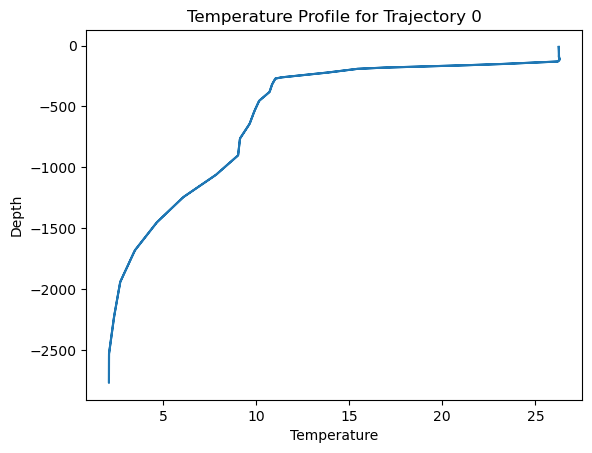

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:12:00'), 'temperature': 26.256418228149414, 'salinity': 34.966346740722656, 'z': -11.0, 'trajectory': 38, 'obs': 0}


In [4]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Open the Zarr dataset
datadir = r"C:\Users\gvp63\Downloads\results (2)\somalia\results\ctd.zarr"
ds = xr.open_zarr(datadir)

# Inspect dataset
print(ds)

# Count the number of trajectories and observations
num_trajectories = ds.sizes['trajectory']
num_observations = ds.sizes['obs']
print(f"Number of trajectories: {num_trajectories}")
print(f"Number of observations per trajectory: {num_observations}")

# Plot temperature vs depth for the first trajectory
plt.plot(ds['temperature'].isel(trajectory=0), ds['z'].isel(trajectory=0))
plt.xlabel('Temperature')
plt.ylabel('Depth')
plt.title('Temperature Profile for Trajectory 0')
plt.show()

# Reshape dataset to avoid looping
ds_stacked = ds.stack(points=("trajectory", "obs")).reset_index("points")

# Convert to a dictionary efficiently
df = ds_stacked[['lat', 'lon', 'time', 'temperature', 'salinity', 'z']].to_dataframe()
df = df.reset_index(drop=True)  # Drop unnecessary index columns
data = df.to_dict(orient='records')

# Check the first profile
print(data[0])


In [30]:
print(data[80])
print(data[100])
print(data[150])
print(data[220])
print(data[300])
print(data[400])

{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:25:20'), 'temperature': 9.099099159240723, 'salinity': 35.17838668823242, 'z': -811.0, 'trajectory': 38, 'obs': 80}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:28:40'), 'temperature': 8.224143981933594, 'salinity': 35.172183990478516, 'z': -1011.0, 'trajectory': 38, 'obs': 100}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:37:00'), 'temperature': 4.367069721221924, 'salinity': 34.9659538269043, 'z': -1511.0, 'trajectory': 38, 'obs': 150}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-17 23:48:40'), 'temperature': 2.3896257877349854, 'salinity': 34.760215759277344, 'z': -2211.0, 'trajectory': 38, 'obs': 220}
{'lat': 5.029581069946289, 'lon': 49.447757720947266, 'time': Timestamp('2024-09-18 00:02:00'), 'temperature': 2.102433443069458, 'salinity': 34.77864074707031, 'z': -2531.0, 'traj

c:\Users\gvp63\anaconda3\envs\dyoc\Lib\site-packages\shapely\creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


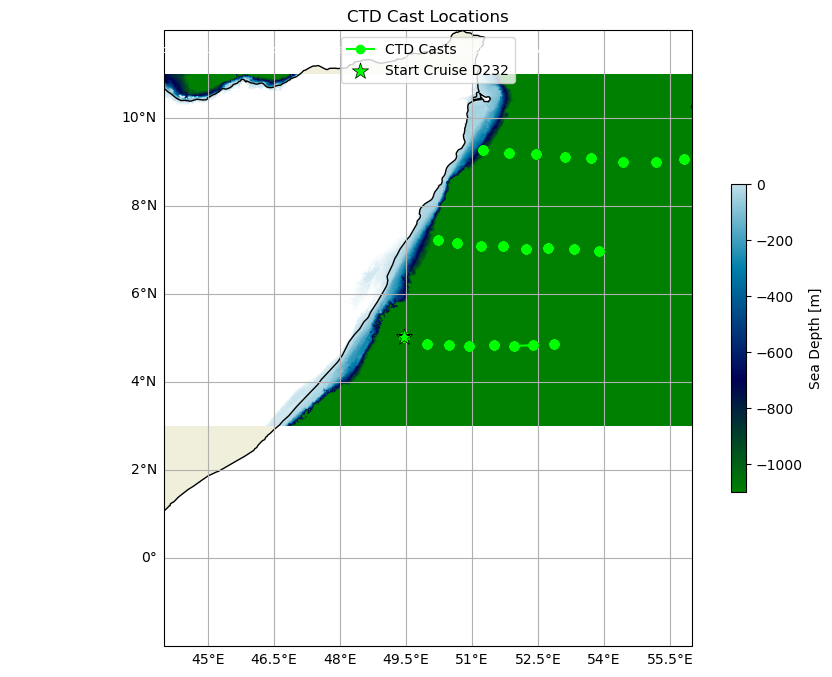

In [5]:
# Load bathymetry data
bathy = xr.open_dataset(r"C:\Users\gvp63\Downloads\gebco_2024_n11.0_s3.0_w44.0_e57.0.nc")

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot bathymetry
tp = ax.pcolormesh(bathy.lon, bathy.lat, bathy.elevation, cmap='ocean', vmin=-1100, vmax=100, transform=ccrs.PlateCarree())

# Add features
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.LAND.with_scale('10m'))
ax.gridlines(draw_labels=['left', 'bottom'], zorder=0)

# Plot CTD cast locations
if data:
    ax.plot([profile['lon'] for profile in data], [profile['lat'] for profile in data], '-o',
            transform=ccrs.PlateCarree(), c='lime', label='CTD Casts')
    ax.scatter(data[0]['lon'], data[0]['lat'], c='lime', marker='*', s=150, zorder=2,
               transform=ccrs.PlateCarree(), edgecolors='k', linewidths=.5, label='Start Cruise D232')
    ax.legend(loc='upper center')
else:
    print("Warning: No CTD data found. Skipping CTD cast locations.")

# Set title and extent
ax.set_title('CTD Cast Locations')
ax.set_extent([44, 56, -2, 12])  # [min_lon, max_lon, min_lat, max_lat]

# Add colorbar
cb = fig.colorbar(tp, ax=ax, shrink=.5)
cb.ax.set_ylim([-1100, 0])
cb.set_label('Sea Depth [m]')

info_text = bathy.attrs.get('title', 'GEBCO 2024 Grid')  # Use 'title' or another available attribute
_ = ax.text(40.5, 11.5, info_text, c='w', fontsize=8)  # Adjust position as needed

plt.show()

In [46]:
from collections import defaultdict

# Group data points by trajectory
grouped_data = defaultdict(list)
for obs in data:
    trajectory = obs['trajectory']
    grouped_data[trajectory].append(obs)

# Convert to a list of profiles (each profile is a trajectory with multiple depth levels)
profiles = []
for trajectory, observations in grouped_data.items():
    # Extract valid (non-NaN) observations
    valid_obs = [
        obs for obs in observations
        if not (np.isnan(obs['salinity']) or 
             np.isnan(obs['temperature']) or 
             np.isnan(obs['z']))
    ]
    
    if not valid_obs:
        continue  # Skip trajectories with no valid data
        
    profiles.append({
    'trajectory': trajectory,
    'density': dens,
    'temperature': temperature, 
    'salinity': salinity, 
    'depth': z,
    'lat': valid_obs[0]['lat'],
    'lon': valid_obs[0]['lon'],
    'transect_id': 3 if valid_obs[0]['lat'] > 8 else 2 if valid_obs[0]['lat'] > 6 else 1
    })
print(profiles[0])
# Constants
alpha_T = 1e-4  # Thermal expansion coefficient
beta_S = 7e-4   # Haline contraction coefficient
dens0 = 1027    # Reference density (kg/m³)

def calc_density(profile, plot=False):
    """
    Calculate density from a profile containing salinity, temperature, and depth.
    
    Parameters:
        profile (dict): A dictionary containing 'salinity', 'temperature', 'z', and 'trajectory'.
    """
    S = profile['salinity']
    T = profile['temperature']
    depth = profile['z']

    # Reference salinity and temperature (surface value)
    S0 = S[0]
    T0 = T[0]

    # Calculate density
    dens = dens0 * (1 - (alpha_T * (T - T0)) + (beta_S * (S - S0)))

    # Plot
    if plot==True:
        plt.figure(figsize=(8, 6))
        plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")
        plt.xlabel('Density (kg/m³)')
        plt.ylabel('Depth (m)')
        plt.title('Density Profile')
        plt.grid()
        plt.legend()
        plt.show()

    return dens

{'trajectory': 38, 'density': array([1027.        , 1026.99940785, 1026.99881296, 1026.99822083,
       1026.99762596, 1026.99703109, 1026.99643899, 1026.99584413,
       1026.99495304, 1026.99373012, 1026.99250997, 1026.99128713,
       1026.99006708, 1026.98884433, 1026.98762163, 1026.98640172,
       1026.98517911, 1026.98395654, 1026.98273677, 1026.98151429,
       1026.98029187, 1026.97906947, 1026.97784715, 1026.9766276 ,
       1026.97540535, 1026.9741859 , 1026.97296375, 1026.97174164,
       1026.97052233, 1026.96929757, 1026.9680756 , 1026.96685642,
       1026.96563454, 1026.96441545, 1026.96319367, 1026.96197194,
       1026.96075298, 1026.95952859, 1026.95830698, 1026.95708817,
       1026.95586666, 1026.95483271, 1026.95441453, 1026.95399083,
       1026.95356986, 1026.95314886, 1026.95272783, 1026.95230679,
       1026.95188299, 1026.95146461, 1026.9510435 , 1026.95062235,
       1026.95020117, 1026.94977723, 1026.94935603, 1026.94893476,
       1026.94851351, 1026.94809

In [7]:
data

[{'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:00'),
  'temperature': 26.256418228149414,
  'salinity': 34.966346740722656,
  'z': -11.0,
  'trajectory': 38,
  'obs': 0},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:10'),
  'temperature': 26.260557174682617,
  'salinity': 34.970802307128906,
  'z': -21.0,
  'trajectory': 38,
  'obs': 1},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:20'),
  'temperature': 26.26323127746582,
  'salinity': 34.97873306274414,
  'z': -31.0,
  'trajectory': 38,
  'obs': 2},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:30'),
  'temperature': 26.26406478881836,
  'salinity': 34.988609313964844,
  'z': -41.0,
  'trajectory': 38,
  'obs': 3},
 {'lat': 5.029581069946289,
  'lon': 49.447757720947266,
  'time': Timestamp('2024-09-17 23:12:40'),
  'temperature': 26.265293

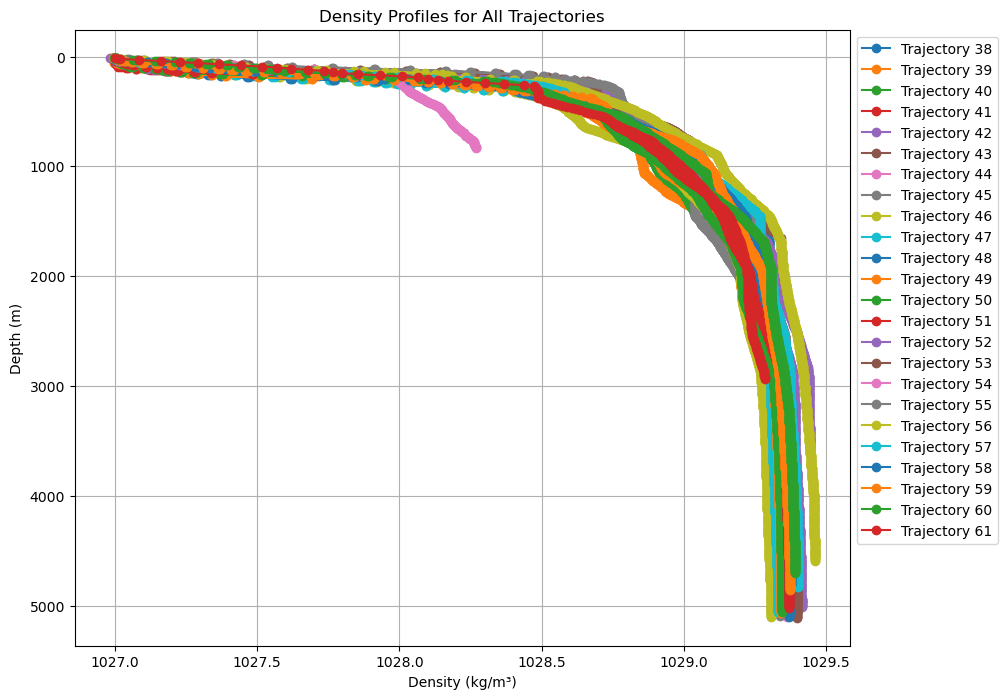

In [8]:
plt.figure(figsize=(10, 8))

for profile in profiles:
    dens = calc_density(profile, plot=False)
    depth = profile['z']
    plt.plot(dens, -depth, 'o-', label=f"Trajectory {profile['trajectory']}")

plt.xlabel('Density (kg/m³)')
plt.ylabel('Depth (m)')
plt.title('Density Profiles for All Trajectories')
plt.grid()
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.gca().invert_yaxis()

# Save the plot
plt.savefig('density_profiles.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
# Constants
g = 9.81  # m/s²
rho0 = 1027  # kg/m³
f = 1e-4  # Coriolis parameter (adjust using f = 2Ωsin(latitude))
dx = 1e4  # Distance between stations (meters). Adjust based on your data!

# Group data by trajectory (assuming each trajectory is a station along the transect)
grouped_data = defaultdict(list)
for obs in data:
    trajectory = obs['trajectory']
    grouped_data[trajectory].append(obs)

# Sort trajectories to ensure correct station order (critical for gradients)
sorted_trajectories = sorted(grouped_data.keys())
profiles = []
for trajectory in sorted_trajectories:
    observations = grouped_data[trajectory]
    # Sort observations by depth (ascending)
    observations_sorted = sorted(observations, key=lambda x: x['z'])
    # Extract valid data (remove NaNs)
    valid_obs = [
        obs for obs in observations_sorted
        if not (np.isnan(obs['salinity']) or np.isnan(obs['temperature']) or np.isnan(obs['z']))
    ]
    if not valid_obs:
        continue
    # Calculate density for the profile
    salinity = np.array([obs['salinity'] for obs in valid_obs])
    temperature = np.array([obs['temperature'] for obs in valid_obs])
    z = np.array([obs['z'] for obs in valid_obs])
    dens = 1027 * (1 - 1e-4 * (temperature - temperature[0]) + 7e-4 * (salinity - salinity[0]))
    profiles.append({
        'trajectory': trajectory,
        'density': dens,
        'depth': z,
        'lat': valid_obs[0]['lat'],
        'lon': valid_obs[0]['lon']
    })

In [10]:
# Extract density and depth arrays for all stations
density_profiles = [profile['density'] for profile in profiles]
depth_profiles = [profile['depth'] for profile in profiles]

# Ensure all profiles have the same depth levels (interpolate if necessary)
# Example: Interpolate to a common depth grid (adjust resolution as needed)
common_depth = np.linspace(np.min([np.min(z) for z in depth_profiles]), 
                           np.max([np.max(z) for z in depth_profiles]), 
                           100)
density_interp = []
for dens, z in zip(density_profiles, depth_profiles):
    dens_interp = np.interp(common_depth, z, dens)
    density_interp.append(dens_interp)

density_interp = np.array(density_interp)  # Shape: (n_stations, n_depth_levels)

# Compute horizontal density gradient (∂ρ/∂x)
drho_dx = np.gradient(density_interp, dx, axis=0)  # axis=0: along stations

In [11]:
# Compute velocity shear (∂u/∂z)
du_dz = (-g / (rho0 * f)) * drho_dx

# Integrate vertically to get velocity (relative to bottom)
dz = np.gradient(common_depth)
u = np.cumsum(du_dz * dz, axis=1)  # Integrate from bottom to surface
u -= u[:, -1:]  # Assume no motion at the surface (adjust if using a different reference)

C:\Users\gvp63\AppData\Local\Temp\ipykernel_19052\1863794911.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s
C:\Users\gvp63\AppData\Local\Temp\ipykernel_19052\1863794911.py:21: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s
C:\Users\gvp63\AppData\Local\Temp\ipykernel_19052\1863794911.py:29: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_transport = np.trapz(transport_per_station, x=x_transect)  # Units: m³/s


Total volume transport: nan m³/s


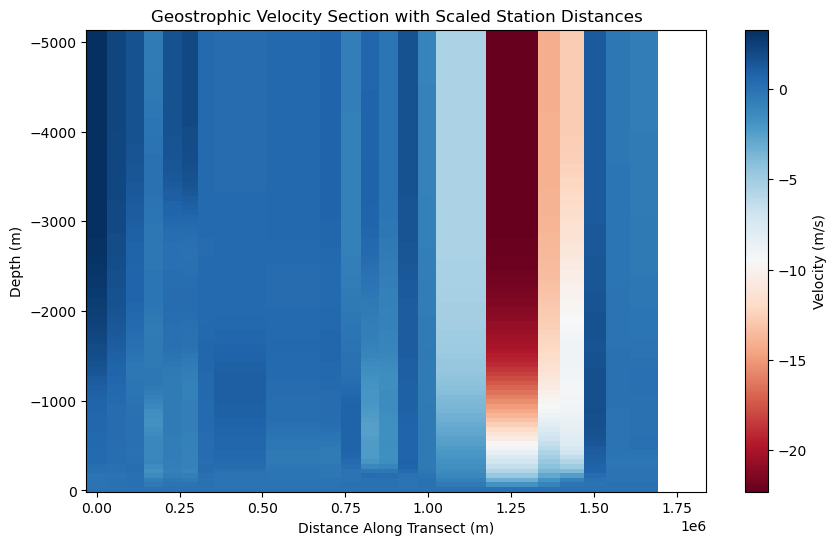

In [ ]:
# Integrate velocity over depth at each station
transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s
#distance between stations..
from geopy.distance import geodesic

# Compute dx dynamically using geodesic distance
dx_list = []
for i in range(1, len(profiles)):  
    lat1, lon1 = profiles[i-1]['lat'], profiles[i-1]['lon']
    lat2, lon2 = profiles[i]['lat'], profiles[i]['lon']
    dx = geodesic((lat1, lon1), (lat2, lon2)).meters
    dx_list.append(dx)

dx_array = np.array(dx_list)

# Ensure dx_array length is one less than the number of stations
if len(dx_array) != len(profiles) - 1:
    raise ValueError(f"dx_array length {len(dx_array)} does not match station count {len(profiles) - 1}")

# Compute transport per station
transport_per_station = np.trapz(u, x=common_depth, axis=1)  # Units: m²/s

# Integrate across the transect using correct dx spacing
x_transect = np.insert(np.cumsum(dx_array), 0, 0)  # Ensure it matches transport_per_station

if len(transport_per_station) != len(x_transect):
    raise ValueError(f"Mismatch: transport_per_station has {len(transport_per_station)} elements, but x_transect has {len(x_transect)}.")

total_transport = np.trapz(transport_per_station, x=x_transect)  # Units: m³/s

print(f"Total volume transport: {total_transport:.2f} m³/s")


# Adjust plot scaling by using actual station distances
X, Z = np.meshgrid(np.insert(np.cumsum(dx_array), 0, 0), common_depth)
plt.figure(figsize=(10, 6))
plt.pcolormesh(X, Z, u.T, cmap='RdBu', shading='auto')
plt.colorbar(label='Velocity (m/s)')
plt.title('Geostrophic Velocity Section with Scaled Station Distances')
plt.xlabel('Distance Along Transect (m)')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.show()


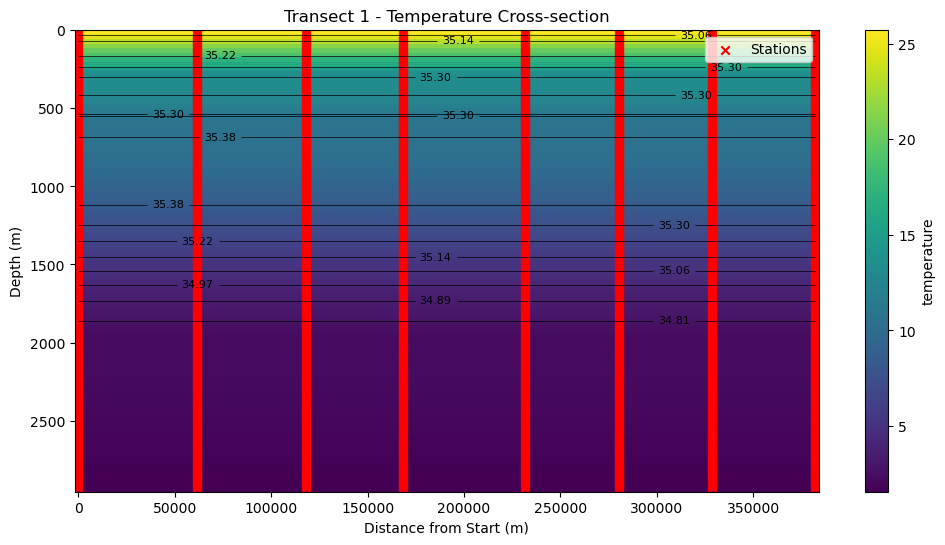

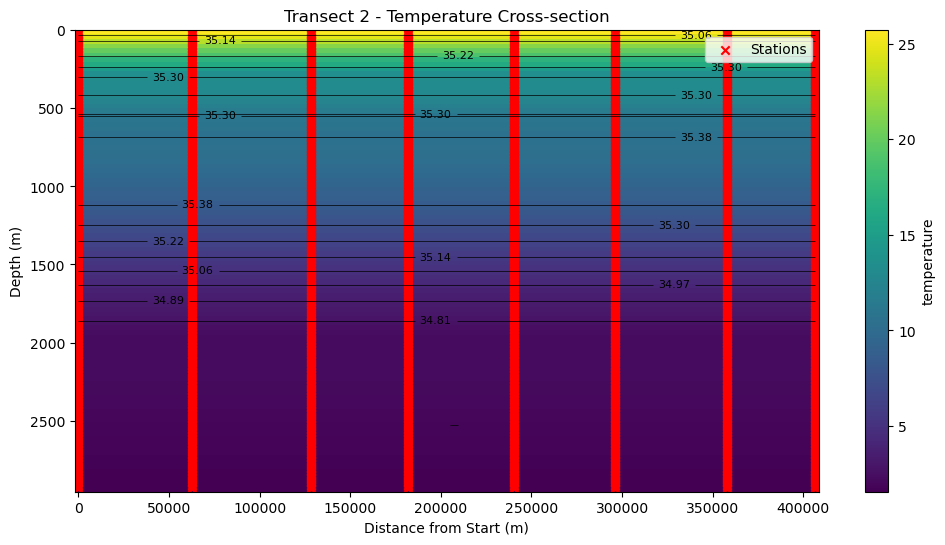

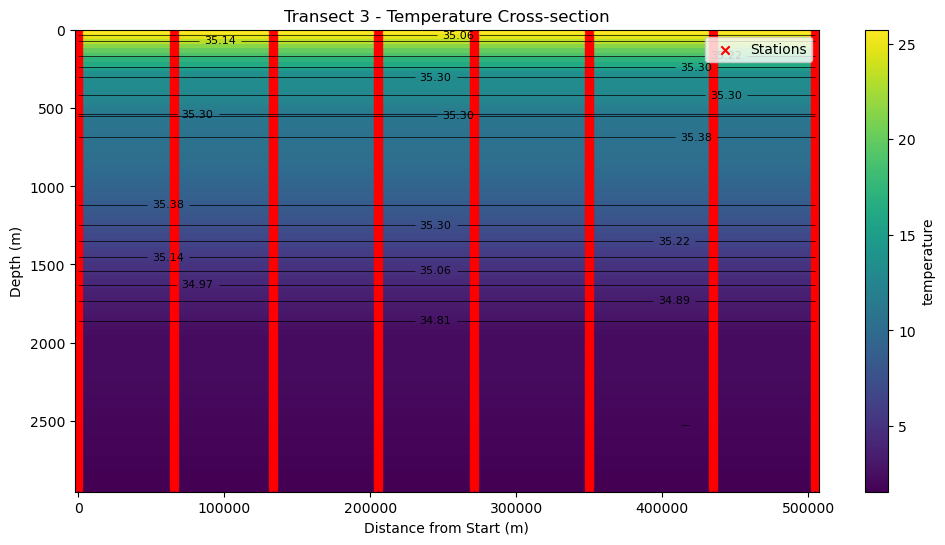

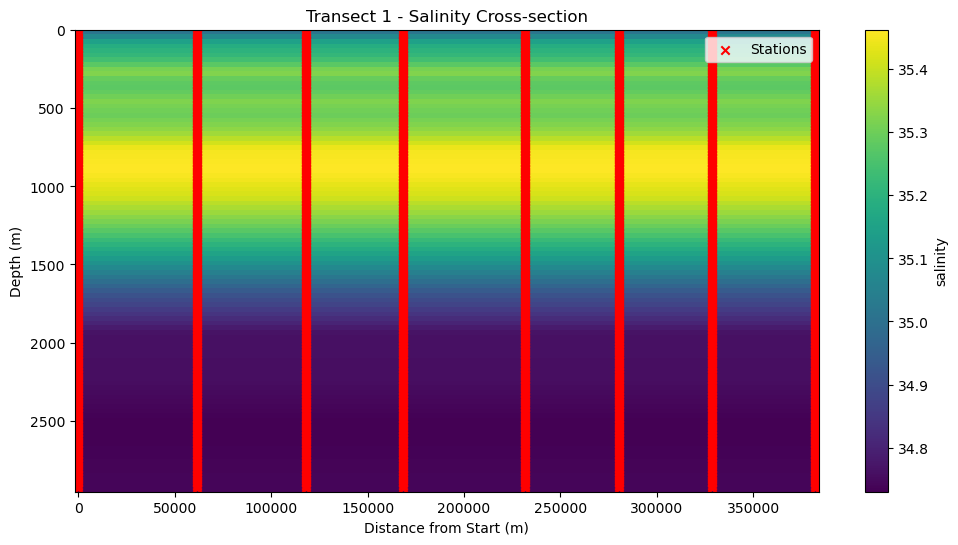

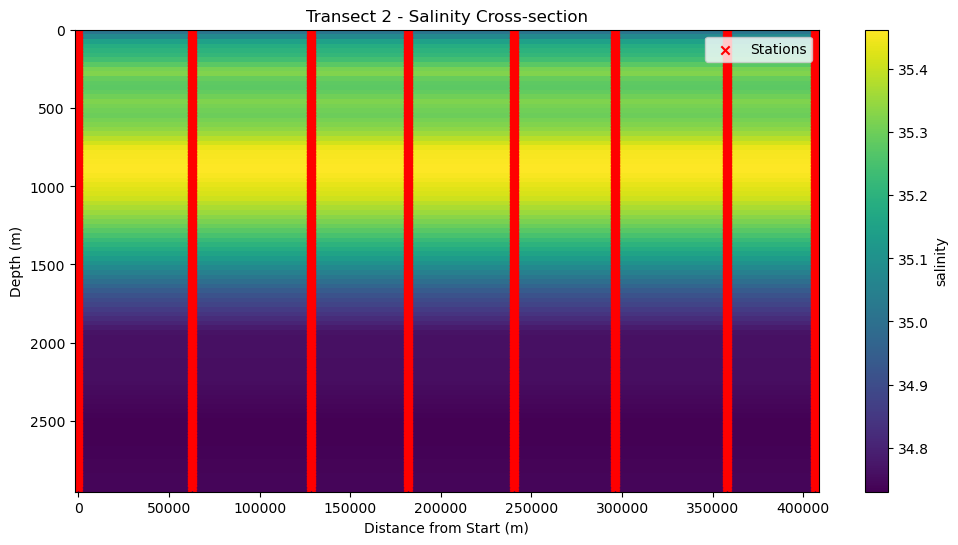

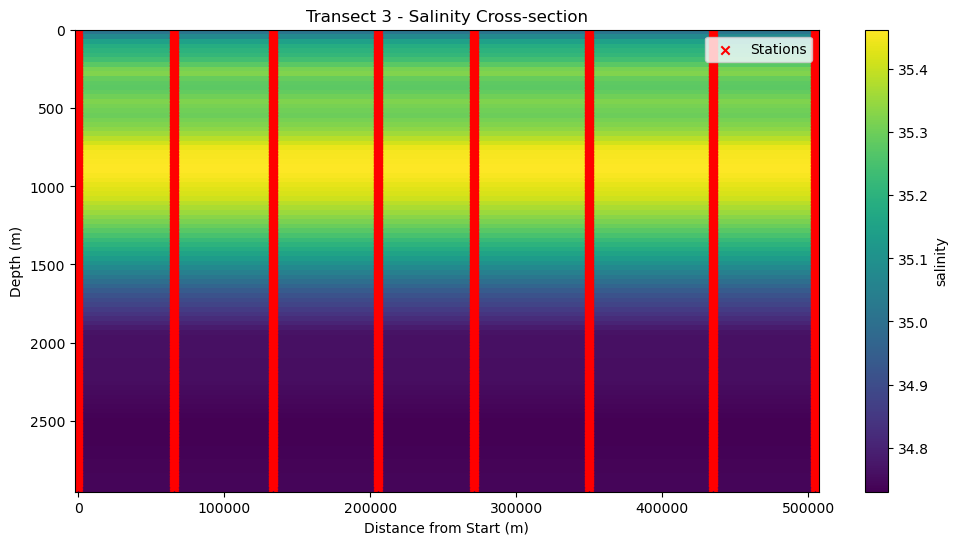

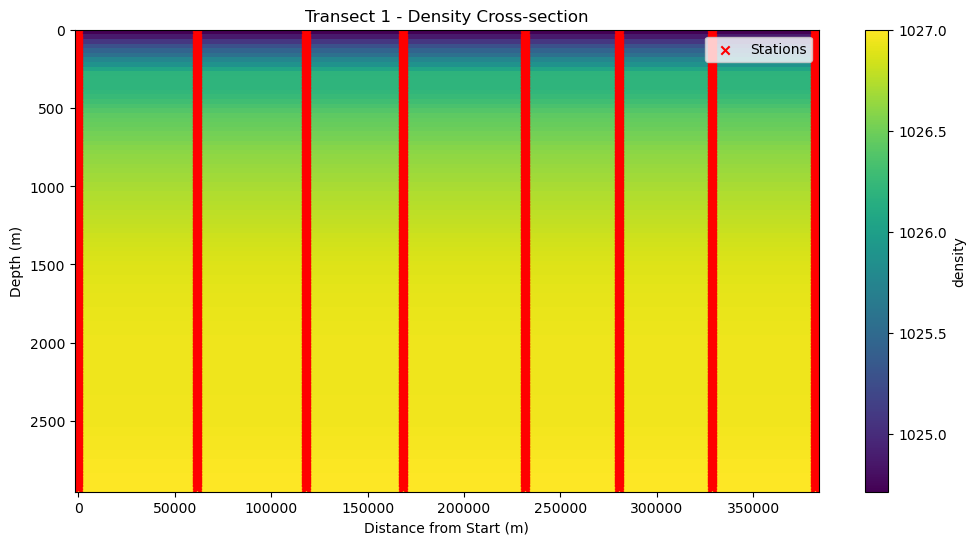

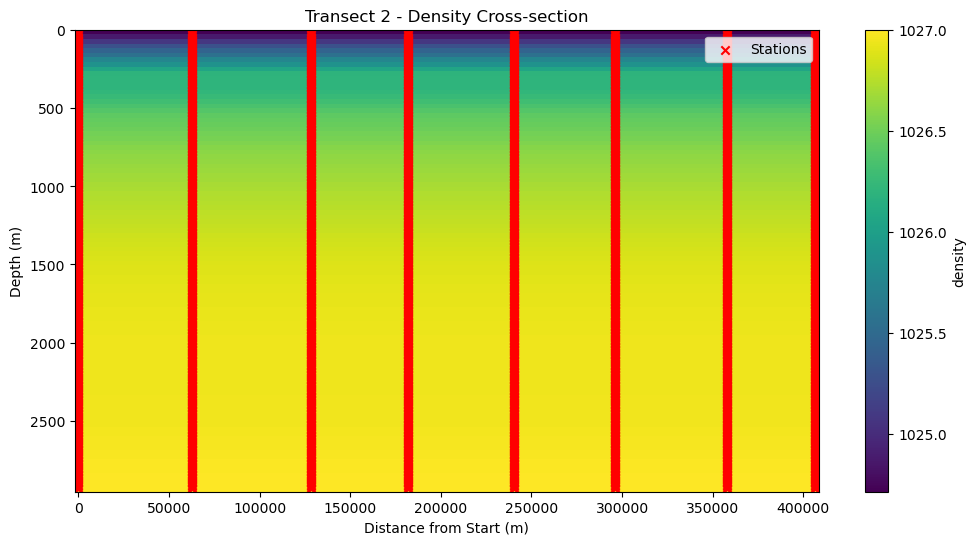

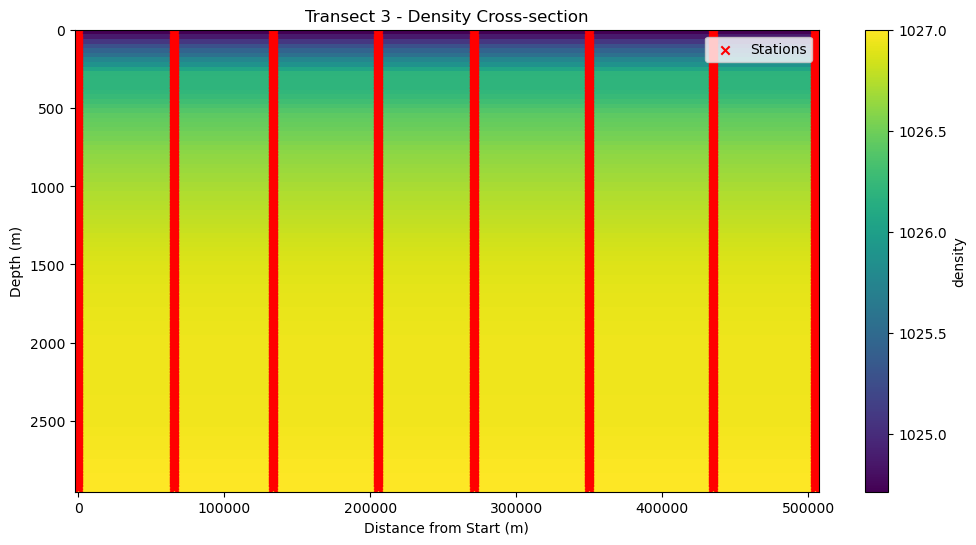

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from geopy.distance import geodesic

def plot_transect_cross_sections(profiles, transect_ids, parameter='temperature', n_interp=100):
    """
    Plot cross-sections for specified transects with interpolation between stations.
    
    Parameters:
        profiles (list): List of profile dictionaries
        transect_ids (list): List of transect IDs to plot
        parameter (str): 'temperature', 'salinity', or 'density'
        n_interp (int): Number of interpolation points between stations
    """
    # Create common depth grid for interpolation
    min_depth = max([np.min(p['depth']) for p in profiles if len(p['depth']) > 0])
    max_depth = np.max([np.max(p['depth']) for p in profiles if len(p['depth']) > 0])
    common_z = np.linspace(min_depth, max_depth, 100)

    for transect_id in transect_ids:
        # Filter profiles for current transect
        transect_profiles = [p for p in profiles if p['transect_id'] == transect_id]
        
        # Skip if no profiles found for this transect
        if not transect_profiles:
            print(f"No profiles found for transect {transect_id}. Skipping.")
            continue
        
        # Calculate cumulative distance along transect
        distances = [0]
        for i in range(1, len(transect_profiles)):
            prev = (transect_profiles[i-1]['lat'], transect_profiles[i-1]['lon'])
            curr = (transect_profiles[i]['lat'], transect_profiles[i]['lon'])
            distances.append(distances[-1] + geodesic(prev, curr).meters)
        
        
        # Create grid for interpolation
        xi = np.linspace(0, distances[-1], n_interp)
        zi = common_z
        xi_grid, zi_grid = np.meshgrid(xi, zi)

        # Interpolate parameter values
        values = []
        salinities = []
        for p in transect_profiles:
            # Skip if depth array is empty
            if len(p['depth']) == 0:
                print(f"Skipping some station in transect {transect_id}: Empty depth array.")
                continue
            # Interpolate to common depth grid
            interp_vals = np.interp(common_z, p['depth'], p[parameter])
            values.append(interp_vals)
            # Interpolate salinity
            sal_interp = np.interp(common_z, p['depth'], p['salinity'])
            salinities.append(sal_interp)
        
        # Skip if no valid values
        if not values:
            print(f"No valid data for transect {transect_id}. Skipping.")
            continue
        
        # Create 2D grid of original points
        x_points = np.repeat(distances, len(common_z))
        z_points = np.tile(common_z, len(transect_profiles))
        values_flat = np.array(values).flatten()
        salinities_flat = np.array(salinities).flatten()

        # Grid the data
        grid = griddata((x_points, z_points), values_flat, (xi_grid, zi_grid), method='linear')
        salinity_grid = griddata((x_points, z_points), salinities_flat, (xi_grid, zi_grid), method='linear')

        # Create plot
        plt.figure(figsize=(12, 6))
        plt.pcolormesh(xi_grid, -zi_grid, grid, shading='auto', cmap='viridis')
        plt.colorbar(label=parameter)
        plt.title(f'Transect {transect_id} - {parameter.capitalize()} Cross-section')
        plt.xlabel('Distance from Start (m)')
        plt.ylabel('Depth (m)')
        plt.gca().invert_yaxis()  # Depth increases downward

        # Add station markings
        for i, p in enumerate(transect_profiles):
            if len(p['depth']) > 0:
                # Plot a marker for each depth level at the station location
                plt.scatter(
                    np.full_like(p['depth'], distances[i]),  # Repeat station distance for each depth
                    -p['depth'],  # Depth values
                    c='red', marker='x', label='Stations' if i == 0 else None
                )
        
        # Add salinity contours (isohalines)
        if parameter == 'temperature':
            levels = np.linspace(np.nanmin(salinity_grid), np.nanmax(salinity_grid), 10)  # Adjust levels as needed
            cs = plt.contour(xi_grid, -zi_grid, salinity_grid, levels=levels, colors='k', linewidths=0.5)
            plt.clabel(cs, inline=True, fontsize=8, fmt='%.2f')  # Label contours

        plt.legend(loc='upper right')
        plt.show()

# Example usage:
# Assuming your profiles have 'transect_id' and 'station_number' fields
transect_ids = [1, 2, 3]  # Replace with your actual transect IDs

# Plot temperature cross-sections
plot_transect_cross_sections(profiles, transect_ids, parameter='temperature')

# Plot salinity cross-sections
plot_transect_cross_sections(profiles, transect_ids, parameter='salinity')

# Plot density cross-sections
plot_transect_cross_sections(profiles, transect_ids, parameter='density')

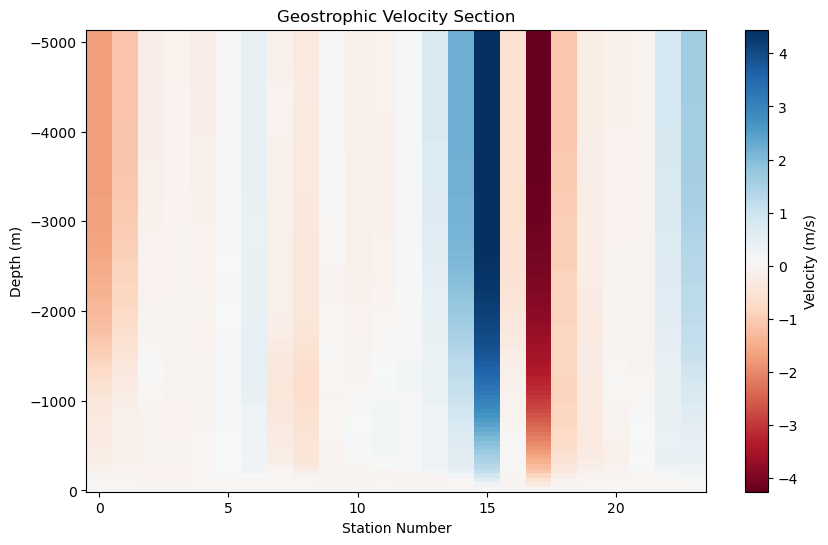

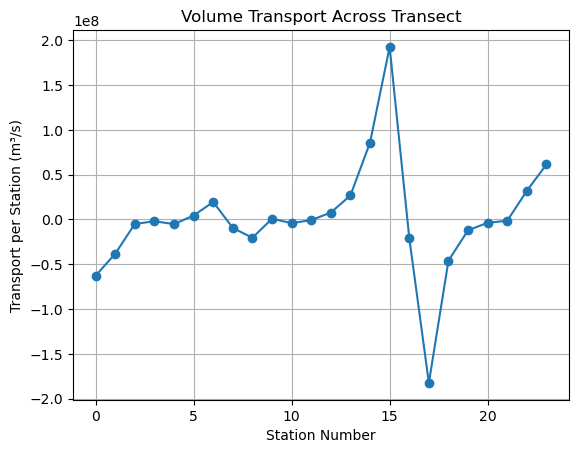

In [13]:
# Plot velocity section
plt.figure(figsize=(10, 6))
X, Z = np.meshgrid(np.arange(len(profiles)), common_depth)
plt.pcolormesh(X, Z, u.T, cmap='RdBu', shading='auto')
plt.colorbar(label='Velocity (m/s)')
plt.title('Geostrophic Velocity Section')
plt.xlabel('Station Number')
plt.ylabel('Depth (m)')
plt.gca().invert_yaxis()
plt.show()

# Plot transport
plt.figure()
plt.plot(np.arange(len(profiles)), transport_per_station * dy, 'o-')
plt.xlabel('Station Number')
plt.ylabel('Transport per Station (m³/s)')
plt.title('Volume Transport Across Transect')
plt.grid()
plt.show()